# Stroke pathway simulation - validation and calibration

## Aims

* Compare predicted predicted (modelled) thrombolysis use against the observed thrombolysis use for each hopsital.

## Pathway simulation overview

The stroke pathway simulation models the passage of a cohort of patients through a hospital's stroke pathway. Timings in the simulation are sampled from distributions using NumPy. These distributions may be based on observed timings or may be ‘what if?’ scenarios such as ‘what if arrival-to-scan time was consistently 15 minutes?’

The process model is based on data available in SSNAP

![](./images/pathway.png)

Individual patient pathways are modelled within a NumPy array for each hospital. The following fields are populated based on sampling from distributions:

```
 0: Patient aged 80+
 1: Allowable onset to needle time (may depend on age)
 2: Onset time known (boolean)
 3: Onset to arrival is less than 4 hours (boolean)
 4: Onset known and onset to arrival is less than 4 hours (boolean)
 5: Onset to arrival minutes
 6: Arrival to scan is less than 4 hours
 7: Arrival to scan minutes
 8: Minutes left to thrombolyse
 9: Onset time known and time left to thrombolyse
10: Proportion ischaemic stroke (if they are filtered at this stage)
11: Assign eligible for thrombolysis (for those scanned within 4 hrs of onset)
12: Thrombolysis planned (scanned within time and eligible)
13: Scan to needle time
14: Clip onset to thrombolysis time to maximum allowed onset-to-thrombolysis
15: Set baseline probability of good outcome based on age group
16: Convert baseline probability good outcome to odds
17: Calculate odds ratio of good outcome based on time to thrombolysis
18: Patient odds of good outcome if given thrombolysis
19: Patient probability of good outcome if given thrombolysis
20: Clip patient probability of good outcome to minimum of zero
21: Individual patient good outcome if given thrombolysis (boolean)*
21: Individual patient good outcome if not given thrombolysis (boolean)*

*Net population outcome is calculated here by summing probabilities of good outcome for all patients, rather than using individual outcomes. These columns are added for potential future use.
```

The outcomes from receiving thrombolysis are based on the decay of effectiveness of thrombolysis as calculated in the meta-analysis by Emberson et al. [1].

In this notebook we use hospital parameters generated by the `extract_hospital_performance.ipynb notebook` which generates pathway distributions based on SSNAP data.

[1] 1 Emberson J, Lees KR, Lyden P, et al. Effect of treatment delay, age, and stroke severity on the effects of intravenous thrombolysis with alteplase for acute ischaemic stroke: A meta-analysis of individual patient data from randomised trials. The Lancet 2014;384:1929–35. doi:10.1016/S0140-6736(14)60584-5

## Import libraries and data

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathway import model_ssnap_pathway_scenarios

# load data from csv and store in pandas dataframe
filename = './hosp_performance_output/hospital_performance.csv'
hospital_performance = pd.read_csv(filename, index_col=0)

## Get results from simulation and save

In [2]:
# Get results of scenarios
results = model_ssnap_pathway_scenarios(hospital_performance, calibration=1.0)

# Save results dataframe  
results_file_name = 'validation.csv'
results.to_csv('results/' + results_file_name)

## Note on precision

* The average 95% confidence interval for thrombolysis use (%) prediction at each hopsital in the base case was +/- 0.28
* The average 95% confidence interval for additional good outcomes per 1,000 admissions prediction at each hopsital in the base case was +/- 0.24

## Compare predicted vs. observed thrombolysis use

In [3]:
predicted = results['Percent_Thrombolysis_(mean)']
observed = hospital_performance['thrombolysis_rate'] * 100

### Calculate R-squared

In [4]:
rsquared = np.corrcoef(predicted, observed) ** 2
rsquared = rsquared[0,1]
print (f'R-Squared {rsquared:0.3f}')

R-Squared 0.979


Plot results

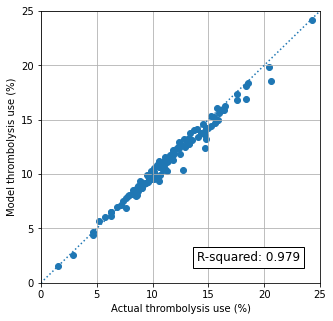

In [5]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(observed, predicted)
ax.set_xlim(0,25)
ax.set_ylim(0,25)
ax.plot([0,25], [0,25], linestyle=':')
ax.grid()
ax.set_xlabel('Actual thrombolysis use (%)')
ax.set_ylabel('Model thrombolysis use (%)')
ax.text(14, 2, f'R-squared: {rsquared:0.3f}', fontsize=12, 
        bbox=dict(facecolor='w', alpha=1.0))
plt.savefig('./results/validation.jpg', dpi=300)

### Calculate errors

In [6]:
mean_observed = np.mean(observed)
mean_predicted = np.mean(predicted)
print (f'Mean observed thrombolysis use: {mean_observed:0.2f}')
print (f'Mean predicted thrombolysis use: {mean_predicted:0.2f}')

Mean observed thrombolysis use: 11.45
Mean predicted thrombolysis use: 11.27


In [7]:
difference = predicted-observed
absolute_difference = abs(predicted-observed)

In [8]:
errors = dict()
errors['Mean difference'] = np.mean(difference)
errors['Std Dev difference'] = np.std(difference)
errors['Mean absolute difference'] = np.mean(absolute_difference)
errors['Std Dev absolute difference'] = np.std(absolute_difference)
errors['Mean percentage difference'] = np.mean(difference / observed) * 100
errors['Std Dev percentage difference'] = np.std(difference / observed) * 100
errors['Mean percentage absolute difference'] = np.mean(
    absolute_difference / observed) * 100
errors['Std Dev percentage absolute difference'] = np.std(
    absolute_difference / observed) * 100

pd.Series(errors)

Mean difference                          -0.188262
Std Dev difference                        0.523398
Mean absolute difference                  0.389702
Std Dev absolute difference               0.396888
Mean percentage difference               -1.327968
Std Dev percentage difference             4.313913
Mean percentage absolute difference       3.382064
Std Dev percentage absolute difference    2.989145
dtype: float64

## Observations

* The model predicts hospital thrombolysis use with very high accuracy.

* The mean predicted per-hospital thrombolysis rate* was 11.46% against a mean observed per-hospital thrombolysis rate* of 11.67%

*Means of thrombolysis rate, weighting all hospitals identically (rather than in proportion to the number of admissions in each hospital).